In [1]:
# Figure 8 from DA6 by American Wood Council, 2007
# Revision History
# 1.1 24-Jul-2019 E.Durham added test data
# 0.0 19-Jul-2019 E.Durham created initial notebook

In [2]:
# Given:
#    span of beam, L in millimetres
#    magnitude of load, P in Newton
#    distance from left end of beam to point of load, a in millimetres
#    distance from left end of beam to point of interest, x in millimetres
#    EI of member, use 1 if unknown; in Newton*millimetres**2
# Derive:
#    distance from right end of beam to point of load, b
#    reactions at ends of beams, R_1 and R_2
#    shear at points of interest
#    bending at points of interest
#    deflection at points of interest
#    plot graphs of shear, moment and deflection

In [3]:
import numpy as np

# Pint Unit Library
from pint import UnitRegistry
unit = UnitRegistry()
Q_ = unit.Quantity
unit.default_format = '~' # ~ for unit abreviations, P for prettyprint, or both
# Define symbols for common units
# Length
m = unit.meter; mm = unit.millimeter; inch = unit.inch;
# Force
N = unit.newton; kN = unit.kilonewton; lbf = unit.pound_force;
# Pressure
kPa = unit.kilopascal; MPa = unit.megapascal; psi = unit.psi; ksi = unit.ksi;
# Mass
kg = unit.kilogram; lbs = unit.pound; 
# Acceleration
g_0 = unit.standard_gravity

SAMPLE_SIZE = 999 # number of discrete points within beam to compute

In [4]:
# Enter case values in units of Newtons and millimetres
P = 1000 * N
a = 1000 * mm
L = 3000 * mm
EI = 1 * N*mm**2 # default
E = 200000 * MPa
I = 0.145*10**6 * mm**4
EI = (E*I).to(N*mm**2)
# Derive distance b
b = L - a
# Calculate Reactions
R_1 = (P*b)/L # reaction at left support
R_2 = (P*a)/L # reaction at right support
# Derive max moment
M_max_value = str(round((P*a*b)/L,3))
M_max_location = a
# Derive max deflection
D_max_value = (P*a*b*(a+2*b)*(3*a*(a+2*b))**0.5)/(27*EI*L)
D_max_value = str(round(D_max_value, 3))
D_max_location = ((a*(a+2*b))/3)**0.5 # ONLY when a > b
D_max_location = str(round(D_max_location, 3))

In [5]:
def shear_x(x, P, a, L):
    """
    Determine shear for simple beam w/ concentrated load at any position x.
    
    where
    x = distance from left end of beam to point of interest
    P = concentrated load
    a = distance from left end of beam to point of load
    L = length of span of beam

    The function does not allign units. Units of x, a and L must be identical. 

    Returns value of shear at x in units_of_P
    
    """
    b = L - a # derive b given a and L
    if x >= 0*x.units and x <= a:
        V_x = (P*b)/L
    elif x > a and x <= L:
        V_x = -(P*a)/L
    else:
        V_x = float('NaN')
        print("Error: x cannot be less than 0 or greater than L which is {} in this case".format(L))
    return V_x

In [6]:
def moment_x(x, P, a, L):
    """
    Determine moment for simple beam w/ concentrated load at any position x.

    where
    x = distance from left end of beam to point of interest
    P = concentrated load
    a = distance from left end of beam to point of load
    L = length of span of beam

    The function does not allign units. Units of x, a and L must be identical. 

    Returns value of moment at x in units_of_P * units_of_x
    """
    b = L - a # derive b given a and L
    if x >= 0*x.units and x <= a:
        M_x = (P*x*b)/L
    elif x > a and x <= L:
        M_x = (P*(L-x)*a)/L
    else:
        M_x = float('NaN')
        print("Error: x cannot be less than 0 or greater than L which is {} in this case".format(L))
    return M_x

In [7]:
def deflection_x(x, P, a, L, EI=1):
    """
    Determine deflection for simple beam w/ concentrated load at any position x.

    where
    x = distance from left end of beam to point of interest
    P = concentrated load
    a = distance from left end of beam to point of load
    L = length of span of beam
    EI = modulus of elasticity of material in units_of_P / units_of_L**2 times
    second moment of area in units_of_L**4. Thus, EI is in units_of_P * units_of_L**2.
    Default value for EI is 1 in which case values returned are overstated by actual value
    of EI. That is, to determine deflection for a given EI, divide deflection here by
    actual value of EI.

    The function does not allign units. Units of x, a and L must be identical. 

    Returns value of deflection at x in units_of_L
    """
    b = L - a # derive b given a and L
    if x == a:
        deflection_x = -(P*a**2*b**2)/(3*EI*L)
    elif x >= 0*x.units and x < a:
        deflection_x = -((P*b*x)/(6*EI*L))*(L**2-b**2-x**2)
    elif x > a and x <= L:
        deflection_x = -((P*a*(L-x))/(6*EI*L))*(2*L*x-x**2-a**2)
    else:
        deflection_x = float('NaN')
        print("Error: x cannot be less than 0 or greater than L which is {} in this case".format(L))
    return deflection_x

In [8]:
# create beam array and load with position, shear, moment and deflection values
beam = np.zeros((4, SAMPLE_SIZE))
POSITION = 0 # array row for position along the beam
SHEAR = 1 # array row for shear along the beam
MOMENT = 2
DEFLECTION = 3
beam[POSITION, : ] = np.linspace(0, L.magnitude, SAMPLE_SIZE) # position
for i in range(SAMPLE_SIZE):
    beam[SHEAR, i] = shear_x(beam[POSITION, i]*L.units, P, a, L).magnitude # stuff shear values
    beam[MOMENT, i] = moment_x(beam[POSITION, i]*L.units, P, a, L).magnitude # stuff moment values
    beam[DEFLECTION, i] = deflection_x(beam[POSITION, i]*L.units, P, a, L, EI).magnitude # stuff deflection values
# beam[0:]

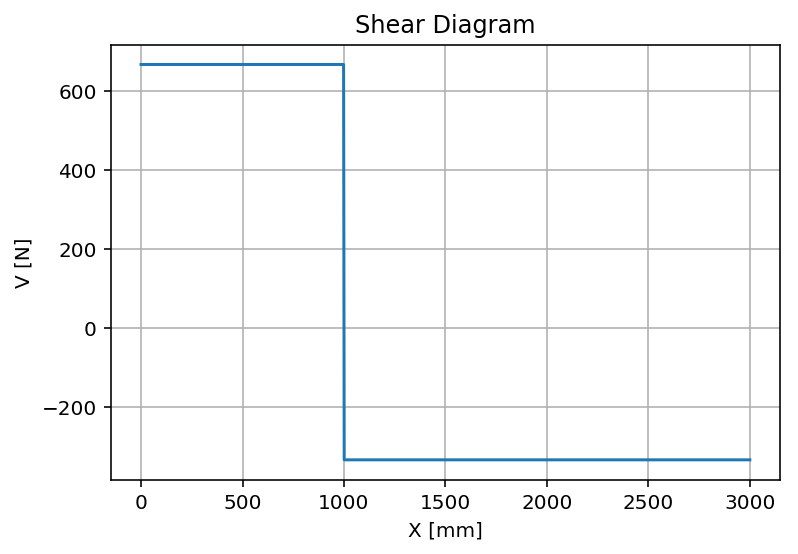

In [9]:
# plot shear diagram with matplotlib
import matplotlib.pyplot as plt
plt.ion()
# %matplotlib inline
ax = plt.plot(beam[POSITION, : ], beam[SHEAR, : ])
plt.grid(b=True, which='both', axis='both')
plt.xlabel(str('X [' + str(L.units) + ']'))
plt.ylabel(str('V [' + str(P.units) + ']'))
plt.title('Shear Diagram')
# plt.legend()
# cursor = Cursor(ax, useblit=True, color='red', linewidth=2)
plt.show()

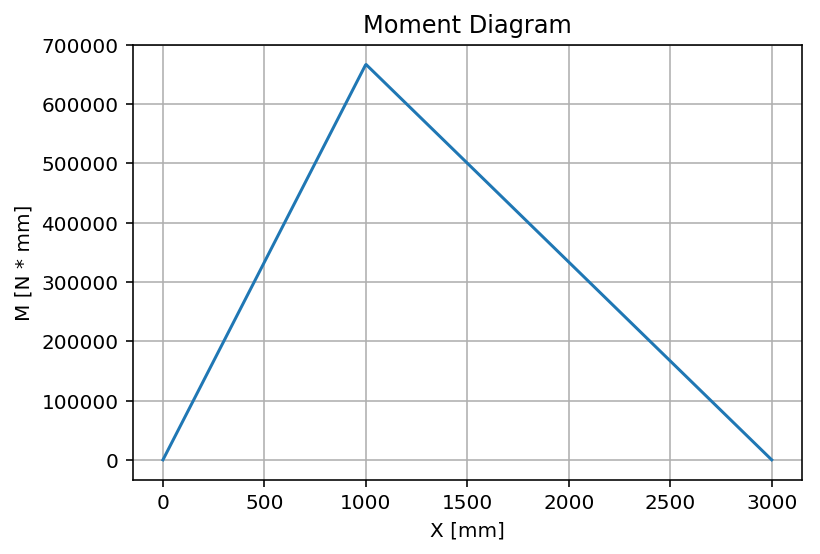

Maximum moment at 1000 mm is 666666.667 N * mm


In [10]:
# from matplotlib.widgets import Cursor
bx = plt.plot(beam[POSITION, : ], beam[MOMENT, : ])
plt.grid(b=True, which='both', axis='both')
plt.xlabel(str('X [' + str(L.units) + ']'))
plt.ylabel(str('M [' + str(P.units * L.units) + ']'))
plt.title('Moment Diagram')
# plt.legend()
# cursor = Cursor(ax, useblit=True, color='red', linewidth=2)
plt.show()
print('Maximum moment at {} is {}'.format(M_max_location, M_max_value))

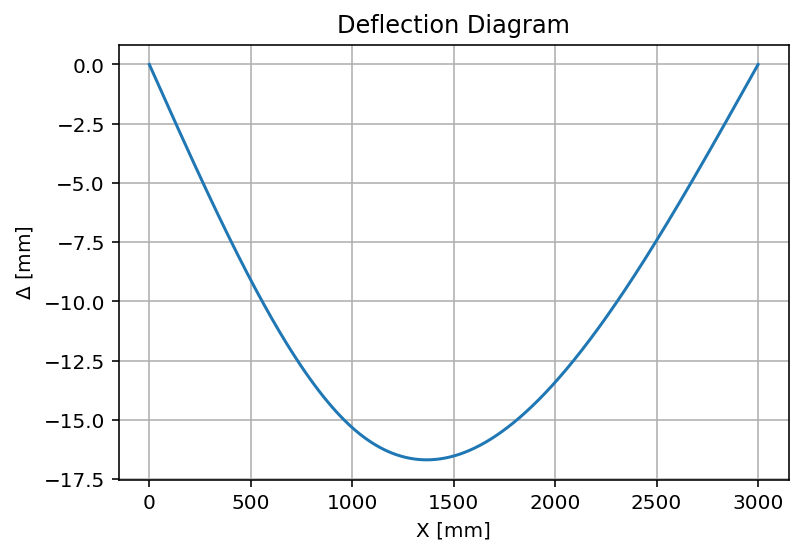

Location of maximum deflection: 1367.7355 mm
Value of maximum deflection: -16.6845 mm


In [11]:
# plot deflection diagram
cx = plt.plot(beam[POSITION, : ], beam[DEFLECTION, : ])
plt.grid(b=True, which='both', axis='both')
plt.xlabel(str('X [' + str(L.units) + ']'))
plt.ylabel('$\Delta$'+ ' [' + str(L.units) + ']')
plt.title('Deflection Diagram')
# plt.legend()
plt.show()
# print('Maximum deflection at {} is {}'.format(D_max_location, D_max_value))
D_index = beam[DEFLECTION, : ].argmin()
D_value = beam[DEFLECTION, D_index]
D_location = beam[POSITION, D_index]

print('Location of maximum deflection: {} mm'.format(round(D_location, 4)))
print('Value of maximum deflection: {} mm'.format(round(D_value, 4)))

In [12]:
# Begin of Test and ancillary data

In [13]:
D_index = beam[DEFLECTION, : ].argmin()
D_value = beam[DEFLECTION, D_index]
D_location = beam[POSITION, D_index]
print(D_index)
print(D_value)
print(D_location)

455
-16.68447176766191
1367.7354709418837


In [14]:
F_y = 350*MPa
F_y.ito(kN/m**2)
E.to(kN/m**2)

<Quantity(200000000.0, 'kilonewton / meter ** 2')>

In [15]:
steel_density = 7850 * kg/m**3
steel_density_for_STAAD = steel_density * g_0
steel_density_for_STAAD.ito(kN/m**3)
steel_density_for_STAAD

<Quantity(76.9822025, 'kilonewton / meter ** 3')>

In [16]:
steel_shear_modulus = 77_000*MPa
steel_shear_modulus.to(kN/m**2)

<Quantity(77000000.0, 'kilonewton / meter ** 2')>